In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import warnings
warnings.filterwarnings('ignore')

## Reading JSON File into Dataframe

In [5]:
MyList = []
for chunk in pd.read_json('ukraine_stream_big.jsonl', lines = True, chunksize = 50):
    MyList.append(chunk)

In [6]:
df = pd.concat(MyList, axis=0)

In [7]:
df.head(5)

attachments            author_id  \
0                                                 {}  1387493777955336192   
1                                                 {}            718781298   
2  {'media_keys': ['3_1573014131929763841'], 'med...  1516126340008878080   
3                                                 {}   702412861042196480   
4                                                 {}             41108484   

                                 context_annotations      conversation_id  \
0  [{'domain': {'id': '123', 'name': 'Ongoing New...  1573014137533235200   
1  [{'domain': {'id': '123', 'name': 'Ongoing New...  1572585751652757504   
2                                                NaN  1573003265150795776   
3  [{'domain': {'id': '123', 'name': 'Ongoing New...  1573014135776104448   
4                                                NaN  1573014138183352320   

                 created_at  \
0 2022-09-22 18:19:30+00:00   
1 2022-09-22 18:19:30+00:00   
2 2022-09-22 18:19:29+00:00   
3 2022-09-22 18:19:29+00:00   
4 2022-09-22 18:19:30+00:00   

                                            entities geo                   id  \
0  {'annotations': [{'start': 24, 'end': 29, 'pro...  {}  1573014137533235200   
1  {'annotations': [{'start': 14, 'end': 16, 'pro...  {}  1573014137688723456   
2  {'mentions': [{'start': 0, 'end': 14, 'usernam...  {}  1573014135813595136   
3  {'hashtags': [{'start': 30, 'end': 46, 'tag': ...  {}  1573014135776104448   
4  {'annotations': [{'start': 31, 'end': 44, 'pro...  {}  1573014138183352320   

  lang  possibly_sensitive  ...  \
0   en               False  ...   
1   en               False  ...   
2   de               False  ...   
3   en               False  ...   
4   en               False  ...   

                                   referenced_tweets reply_settings  \
0  [{'type': 'retweeted', 'id': '1572982488540106...       everyone   
1  [{'type': 'replied_to', 'id': '157258575165275...       everyone   
2  [{'type': 'replied_to', 'id': '157300326515079...       everyone   
3  [{'type': 'retweeted', 'id': '1573007132823359...       everyone   
4  [{'type': 'retweeted', 'id': '1572972092244766...       everyone   

                source                                               text  \
0   Twitter for iPhone  RT @EndGameWW3: Update: Lavrov: Countries that...   
1   Twitter for iPhone  @charlesadler UKR  had 3-4 suited connectors a...   
2  Twitter for Android  @Anonymous9775 Keiner wird durchmaschieren htt...   
3   Twitter for iPhone  RT @Ulkoministerio: The @OSCE #MoscowMechanism...   
4  Twitter for Android  RT @mbk_center: 🇷🇺 IT expert Viktor Burgeev (3...   

                                              author  \
0  {'created_at': '2021-04-28T19:48:10.000Z', 'de...   
1  {'created_at': '2012-07-26T21:16:21.000Z', 'de...   
2  {'created_at': '2022-04-18T18:47:54.000Z', 'de...   
3  {'created_at': '2016-02-24T08:40:51.000Z', 'de...   
4  {'created_at': '2009-05-19T12:52:40.000Z', 'de...   

                                             __twarc  \
0  {'url': 'https://api.twitter.com/2/tweets/sear...   
1  {'url': 'https://api.twitter.com/2/tweets/sear...   
2  {'url': 'https://api.twitter.com/2/tweets/sear...   
3  {'url': 'https://api.twitter.com/2/tweets/sear...   
4  {'url': 'https://api.twitter.com/2/tweets/sear...   

                                      matching_rules in_reply_to_user_id  \
0         [{'id': '1572745861951819778', 'tag': ''}]                 NaN   
1  [{'id': '1572745861951819778', 'tag': ''}, {'i...        1.621950e+07   
2  [{'id': '1572745861951819778', 'tag': ''}, {'i...        1.516039e+18   
3         [{'id': '1572745850035802112', 'tag': ''}]                 NaN   
4  [{'id': '1572745861951819778', 'tag': ''}, {'i...                 NaN   

                                    in_reply_to_user withheld  
0                                                NaN      NaN  
1  {'created_at': '2008-09-10T11:28:53.000Z', 'de...      NaN  
2  {'created_at':

## Sentiment Analysis

In [8]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [9]:
# Cleaning the text field
#cleaning the tweets
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt
def clean_tweets(tweets):
    #remove twitter Return handles (RT @xxx:)
    tweets = np.vectorize(remove_pattern)(tweets, "RT @[\w]*:") 
    
    #remove twitter handles (@xxx)
    tweets = np.vectorize(remove_pattern)(tweets, "@[\w]*")
    
    #remove URL links (httpxxx)
    tweets = np.vectorize(remove_pattern)(tweets, "https?://[A-Za-z0-9./]*")
    
    #remove special characters, numbers, punctuations (except for #)
    tweets = np.core.defchararray.replace(tweets, "[^a-zA-Z]", " ")
    
    return tweets


df['Tweet'] = clean_tweets(df['text'])
df['Tweet'].head()

0     Update: Lavrov: Countries that support Ukrain...
1     UKR  had 3-4 suited connectors and RU had JJ ...
2                         Keiner wird durchmaschieren 
3     The  #MoscowMechanism report shows that #Russ...
4     🇷🇺 IT expert Viktor Burgeev (32) with zero mi...
Name: Tweet, dtype: object

In [10]:
scores = []
# Declare variables for scores
compound_list = []
positive_list = []
negative_list = []
neutral_list = []
for i in range(df['Tweet'].shape[0]):
#print(analyser.polarity_scores(sentiments_pd['text'][i]))
    compound = analyzer.polarity_scores(df['Tweet'][i])["compound"]
    pos = analyzer.polarity_scores(df['Tweet'][i])["pos"]
    neu = analyzer.polarity_scores(df['Tweet'][i])["neu"]
    neg = analyzer.polarity_scores(df['Tweet'][i])["neg"]
    
    scores.append({"Compound": compound,
                       "Positive": pos,
                       "Negative": neg,
                       "Neutral": neu
                  })
    
sentiments_score = pd.DataFrame.from_dict(scores)
df = df.join(sentiments_score)
df.head()

attachments            author_id  \
0                                                 {}  1387493777955336192   
1                                                 {}            718781298   
2  {'media_keys': ['3_1573014131929763841'], 'med...  1516126340008878080   
3                                                 {}   702412861042196480   
4                                                 {}             41108484   

                                 context_annotations      conversation_id  \
0  [{'domain': {'id': '123', 'name': 'Ongoing New...  1573014137533235200   
1  [{'domain': {'id': '123', 'name': 'Ongoing New...  1572585751652757504   
2                                                NaN  1573003265150795776   
3  [{'domain': {'id': '123', 'name': 'Ongoing New...  1573014135776104448   
4                                                NaN  1573014138183352320   

                 created_at  \
0 2022-09-22 18:19:30+00:00   
1 2022-09-22 18:19:30+00:00   
2 2022-09-22 18:19:29+00:00   
3 2022-09-22 18:19:29+00:00   
4 2022-09-22 18:19:30+00:00   

                                            entities geo                   id  \
0  {'annotations': [{'start': 24, 'end': 29, 'pro...  {}  1573014137533235200   
1  {'annotations': [{'start': 14, 'end': 16, 'pro...  {}  1573014137688723456   
2  {'mentions': [{'start': 0, 'end': 14, 'usernam...  {}  1573014135813595136   
3  {'hashtags': [{'start': 30, 'end': 46, 'tag': ...  {}  1573014135776104448   
4  {'annotations': [{'start': 31, 'end': 44, 'pro...  {}  1573014138183352320   

  lang  possibly_sensitive  ...  \
0   en               False  ...   
1   en               False  ...   
2   de               False  ...   
3   en               False  ...   
4   en               False  ...   

                                             __twarc  \
0  {'url': 'https://api.twitter.com/2/tweets/sear...   
1  {'url': 'https://api.twitter.com/2/tweets/sear...   
2  {'url': 'https://api.twitter.com/2/tweets/sear...   
3  {'url': 'https://api.twitter.com/2/tweets/sear...   
4  {'url': 'https://api.twitter.com/2/tweets/sear...   

                                      matching_rules in_reply_to_user_id  \
0         [{'id': '1572745861951819778', 'tag': ''}]                 NaN   
1  [{'id': '1572745861951819778', 'tag': ''}, {'i...        1.621950e+07   
2  [{'id': '1572745861951819778', 'tag': ''}, {'i...        1.516039e+18   
3         [{'id': '1572745850035802112', 'tag': ''}]                 NaN   
4  [{'id': '1572745861951819778', 'tag': ''}, {'i...                 NaN   

                                    in_reply_to_user withheld  \
0                                                NaN      NaN   
1  {'created_at': '2008-09-10T11:28:53.000Z', 'de...      NaN   
2  {'created_at': '2022-04-18T13:01:44.000Z', 'de...      NaN   
3                                                NaN      NaN   
4                                                NaN      NaN   

                                               Tweet Compound Positive  \
0   Update: Lavrov: Countries that support Ukrain...  -0.6249    0.132   
1   UKR  had 3-4 suited connectors and RU had JJ ...   0.2395    0.065   
2                       Keiner wird durchmaschieren    0.0000    0.000   
3   The  #MoscowMechanism report shows that #Russ...  -0.1027    0.124   
4   🇷🇺 IT expert Viktor Burgeev (32) with zero mi...   0.0000    0.000   

   Negative Neutral  
0     0.332   0.537  
1     0.066   0.869  
2     0.000   1.000  
3     0.146   0.730  
4     0.000   1.000  

[5 rows x 26 columns]

In [11]:
# create a list of our conditions
conditions = [
    (df['Compound'] <= -0.5),
    (df['Compound'] > -0.5) & (df['Compound'] < 0.5),
    (df['Compound'] > 0.5)
    ]

# create a list of the values we want to assign for each condition
values = ['Negative', 'Neutral', 'Positive']

# create a new column and use np.select to assign values to it using our lists as arguments
df['Category'] = np.select(conditions, values)
df.head()

attachments            author_id  \
0                                                 {}  1387493777955336192   
1                                                 {}            718781298   
2  {'media_keys': ['3_1573014131929763841'], 'med...  1516126340008878080   
3                                                 {}   702412861042196480   
4                                                 {}             41108484   

                                 context_annotations      conversation_id  \
0  [{'domain': {'id': '123', 'name': 'Ongoing New...  1573014137533235200   
1  [{'domain': {'id': '123', 'name': 'Ongoing New...  1572585751652757504   
2                                                NaN  1573003265150795776   
3  [{'domain': {'id': '123', 'name': 'Ongoing New...  1573014135776104448   
4                                                NaN  1573014138183352320   

                 created_at  \
0 2022-09-22 18:19:30+00:00   
1 2022-09-22 18:19:30+00:00   
2 2022-09-22 18:19:29+00:00   
3 2022-09-22 18:19:29+00:00   
4 2022-09-22 18:19:30+00:00   

                                            entities geo                   id  \
0  {'annotations': [{'start': 24, 'end': 29, 'pro...  {}  1573014137533235200   
1  {'annotations': [{'start': 14, 'end': 16, 'pro...  {}  1573014137688723456   
2  {'mentions': [{'start': 0, 'end': 14, 'usernam...  {}  1573014135813595136   
3  {'hashtags': [{'start': 30, 'end': 46, 'tag': ...  {}  1573014135776104448   
4  {'annotations': [{'start': 31, 'end': 44, 'pro...  {}  1573014138183352320   

  lang  possibly_sensitive  ...  \
0   en               False  ...   
1   en               False  ...   
2   de               False  ...   
3   en               False  ...   
4   en               False  ...   

                                      matching_rules in_reply_to_user_id  \
0         [{'id': '1572745861951819778', 'tag': ''}]                 NaN   
1  [{'id': '1572745861951819778', 'tag': ''}, {'i...        1.621950e+07   
2  [{'id': '1572745861951819778', 'tag': ''}, {'i...        1.516039e+18   
3         [{'id': '1572745850035802112', 'tag': ''}]                 NaN   
4  [{'id': '1572745861951819778', 'tag': ''}, {'i...                 NaN   

                                    in_reply_to_user withheld  \
0                                                NaN      NaN   
1  {'created_at': '2008-09-10T11:28:53.000Z', 'de...      NaN   
2  {'created_at': '2022-04-18T13:01:44.000Z', 'de...      NaN   
3                                                NaN      NaN   
4                                                NaN      NaN   

                                               Tweet Compound Positive  \
0   Update: Lavrov: Countries that support Ukrain...  -0.6249    0.132   
1   UKR  had 3-4 suited connectors and RU had JJ ...   0.2395    0.065   
2                       Keiner wird durchmaschieren    0.0000    0.000   
3   The  #MoscowMechanism report shows that #Russ...  -0.1027    0.124   
4   🇷🇺 IT expert Viktor Burgeev (32) with zero mi...   0.0000    0.000   

  Negative  Neutral  Category  
0    0.332    0.537  Negative  
1    0.066    0.869   Neutral  
2    0.000    1.000   Neutral  
3    0.146    0.730   Neutral  
4    0.000    1.000   Neutral  

[5 rows x 27 columns]

In [12]:
pd.DataFrame(df.groupby(['Category'])['Category'].count()).rename(columns={"Category":"Counts"}).assign(
    Percentage=lambda x: (x.Counts/ x.Counts.sum())*100)

Counts  Percentage
Category                    
0              3    0.000607
Negative   98507   19.921614
Neutral   351803   71.147060
Positive   44160    8.930720

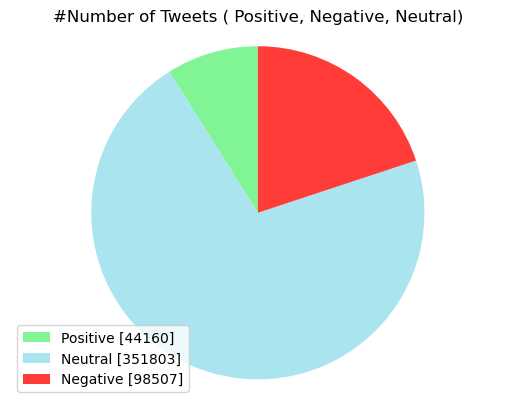

In [20]:
positive=44160
neutral=351803
negative=98507

#Creating PieChart
labels = ['Positive ['+str(positive)+']' , 'Neutral ['+str(neutral)+']','Negative ['+str(negative)+']']
sizes = [positive, neutral, negative]
colors = ["#81F495","#A9E4EF","#FF3C38"]
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title( '#Number of Tweets ( Positive, Negative, Neutral)' )
plt.axis('equal')
plt.show()

In [14]:
#Top 50 positive tweets
df.nlargest(n=50, columns=['Compound'])["Tweet"]

139464    🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣...
169423               🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣...
203682      🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣...
3990        🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣...
59450      Akoa agyimi, ose I have his room number 🤣🤣🤣🤣🤣...
404870    😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂...
221519      PUTIN!😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍🥰🥰🥰🥰🥰🥰🥰🥰😍😍...
388417     😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆......
209769     Journalist 😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂...
117933     "hysterical event"... 🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣...
443371                  🤚🤚🤚🤚🤚🤚🤚🤚🤚🤚🤚🤚🤚🤚🤚🤚🤚🤚🤚🤚🤚🤚🤚🤚🤚🤚🤚🤚🤚🤚🤚🤚🤚🤚🤚
254195          🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣 trollaZZa
338051              "Russia's rich culture"\n🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣...
164155    Putin se ne vuole andare dal potere… 🤣🤣🤣😂🤣🤣😂🤣🤣...
309084      What kind of people are they in England when...
177562                 😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂
350547                                  

In [15]:
#Top 50 negetive tweets
df.nsmallest(n=50, columns=['Compound'])["Tweet"]

384876    😳😳😳😳😳😳😳😳😳😳😳😳😳😳😳😳😳😳😳😳😳😳😳😳😱😱😱😱😱😱😱😱😱😱😱😱😱😱😱😱😱😱😱😱😱😱😱😱 
468462    Never compare Vietnamese farmers fighting off ...
80341     putin sa si mais man plié ti bey ooooolalalaal...
330293     E non si vergognano nemmeno a pubblicare ste ...
369067    Ето так тяжело когда все вакрук нє умаляют тєб...
399048    TRAITOR TRUMP IS BEYOND EVIL!!!\nTHE WAR CRIMI...
283888    💥💥💥💥💥💥💥💥💥💥💥💥💥\n\nVorwärts immer - rückwärts ni...
331404     💥💥💥💥💥💥💥💥💥💥💥💥💥\n\nVorwärts immer - rückwärts n...
371352     💥💥💥💥💥💥💥💥💥💥💥💥💥\n\nVorwärts immer - rückwärts n...
469725      How to stop that movement of weapons &amp; i...
432815     En su afán de destrucción, no ve más allá de ...
53997     💣💣💣💣💣💣💣💣💣💣💣💣💣💣💣\n#Delon #zelensky le deal: \nT...
176150     🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥\n\nHier kann jeder die wahre #Vers...
267251    Human arrogance is despicable! Not only do we ...
269044      Human arrogance is despicable! Not only do w...
304883     💥💥💥💥💥💥💥💥💥💥\n\nкяιєgѕтяєιвєя ѕιη∂ мøєя∂єя\n\n💥...
196656     Each person has the right to 

<AxesSubplot:xlabel='Neutral', ylabel='Density'>

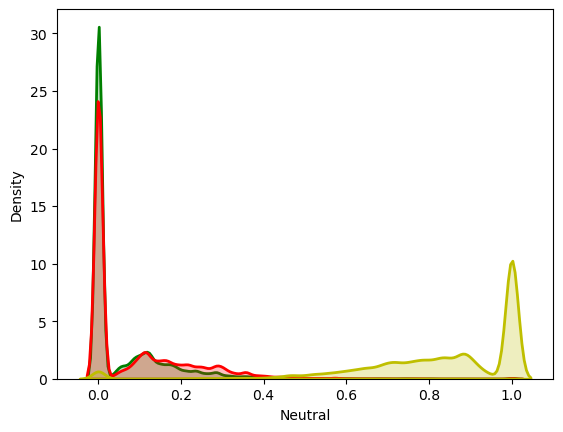

In [16]:
#VIS
sns.distplot(df["Positive"], hist=False, kde=True, 
             bins=int(180/5), color = 'green', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'shade': True,'linewidth': 2})

sns.distplot(df["Negative"], hist=False, kde=True, 
             bins=int(180/5), color = 'red', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'shade': True,'linewidth': 2})

sns.distplot(df["Neutral"], hist=False, kde=True, 
             bins=int(180/5), color = 'y', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'shade': True,'linewidth': 2})

<AxesSubplot:xlabel='Compound', ylabel='Density'>

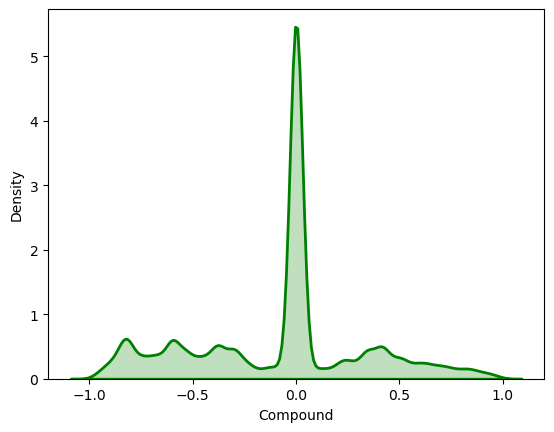

In [17]:
sns.distplot(df["Compound"], hist=False, kde=True, 
             bins=int(180/5), color = 'green', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'shade': True,'linewidth': 2})

     -------------------------------------- 153.1/153.1 kB 4.5 MB/s eta 0:00:00


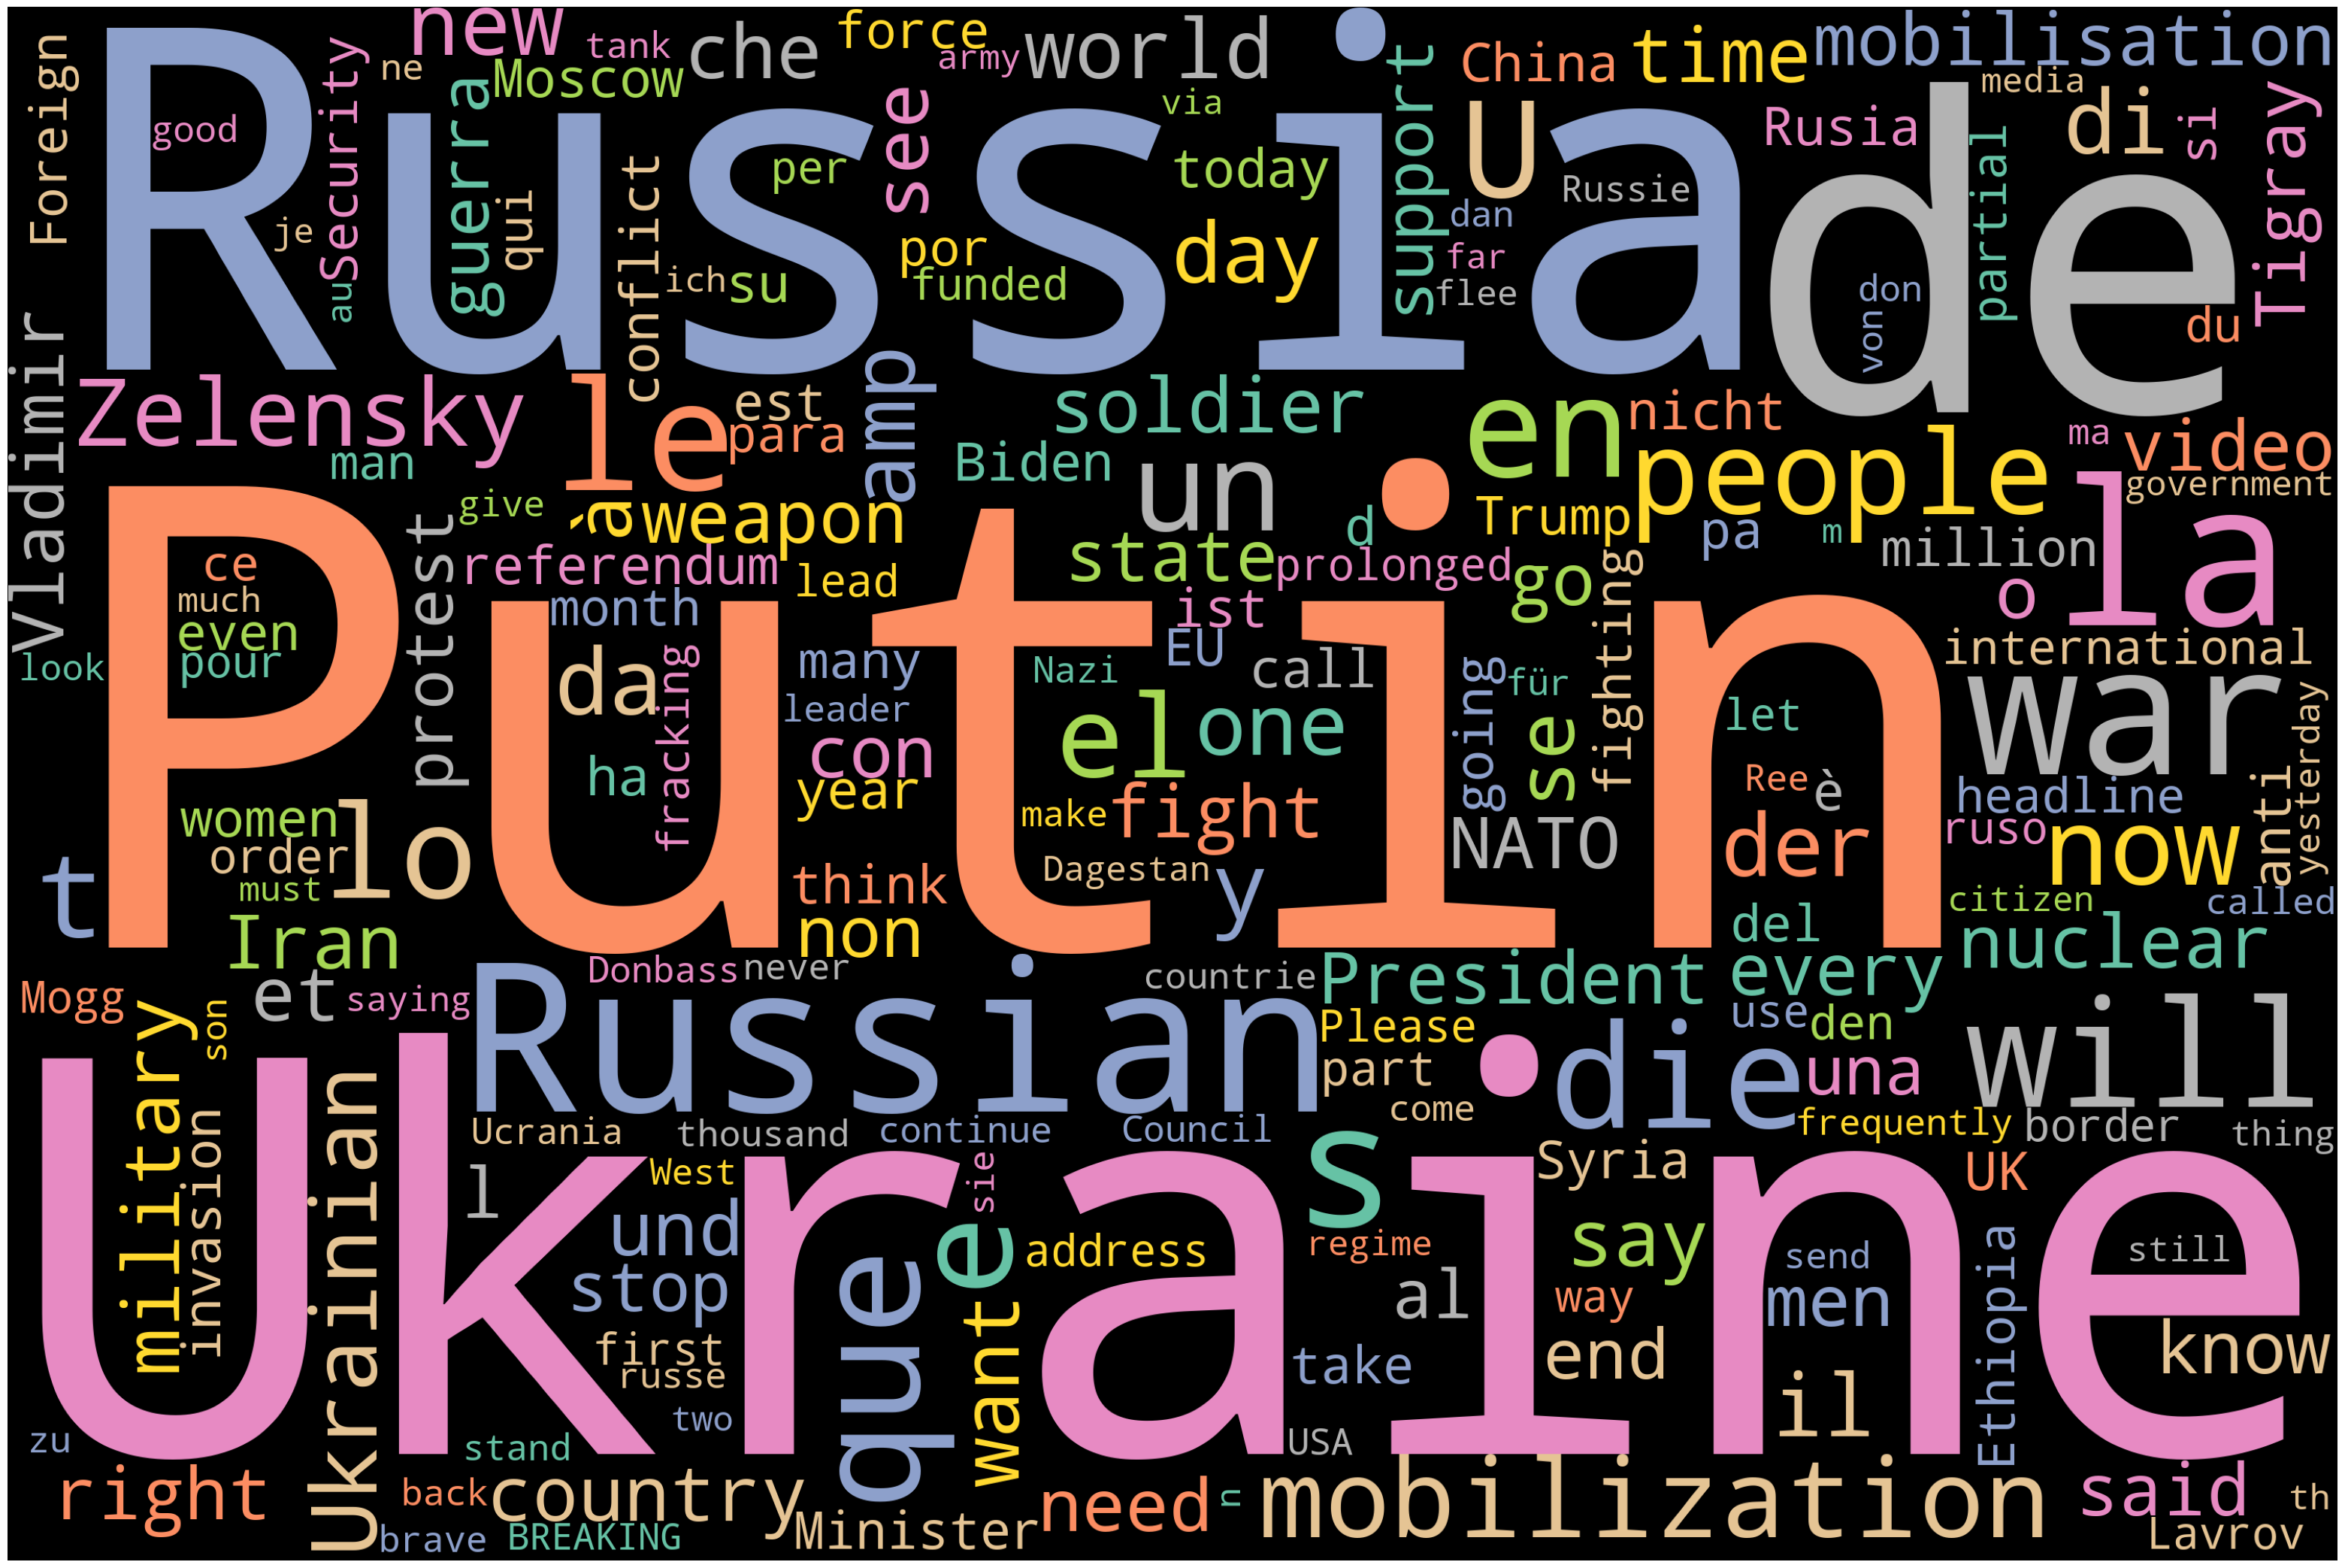

In [21]:
#WordCount
!pip install wordcloud
from wordcloud import WordCloud , STOPWORDS , ImageColorGenerator
from nltk import *

#function to display wordcloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");



### Word Cloud of mostly used word in Tweets
text = " ".join(review for review in df.Tweet)
wordcloud = WordCloud(width = 3000, height = 2000, stopwords=STOPWORDS, background_color="Black",colormap='Set2', collocations=False).generate(text)
 ### Display the generated image:

plot_cloud(wordcloud)

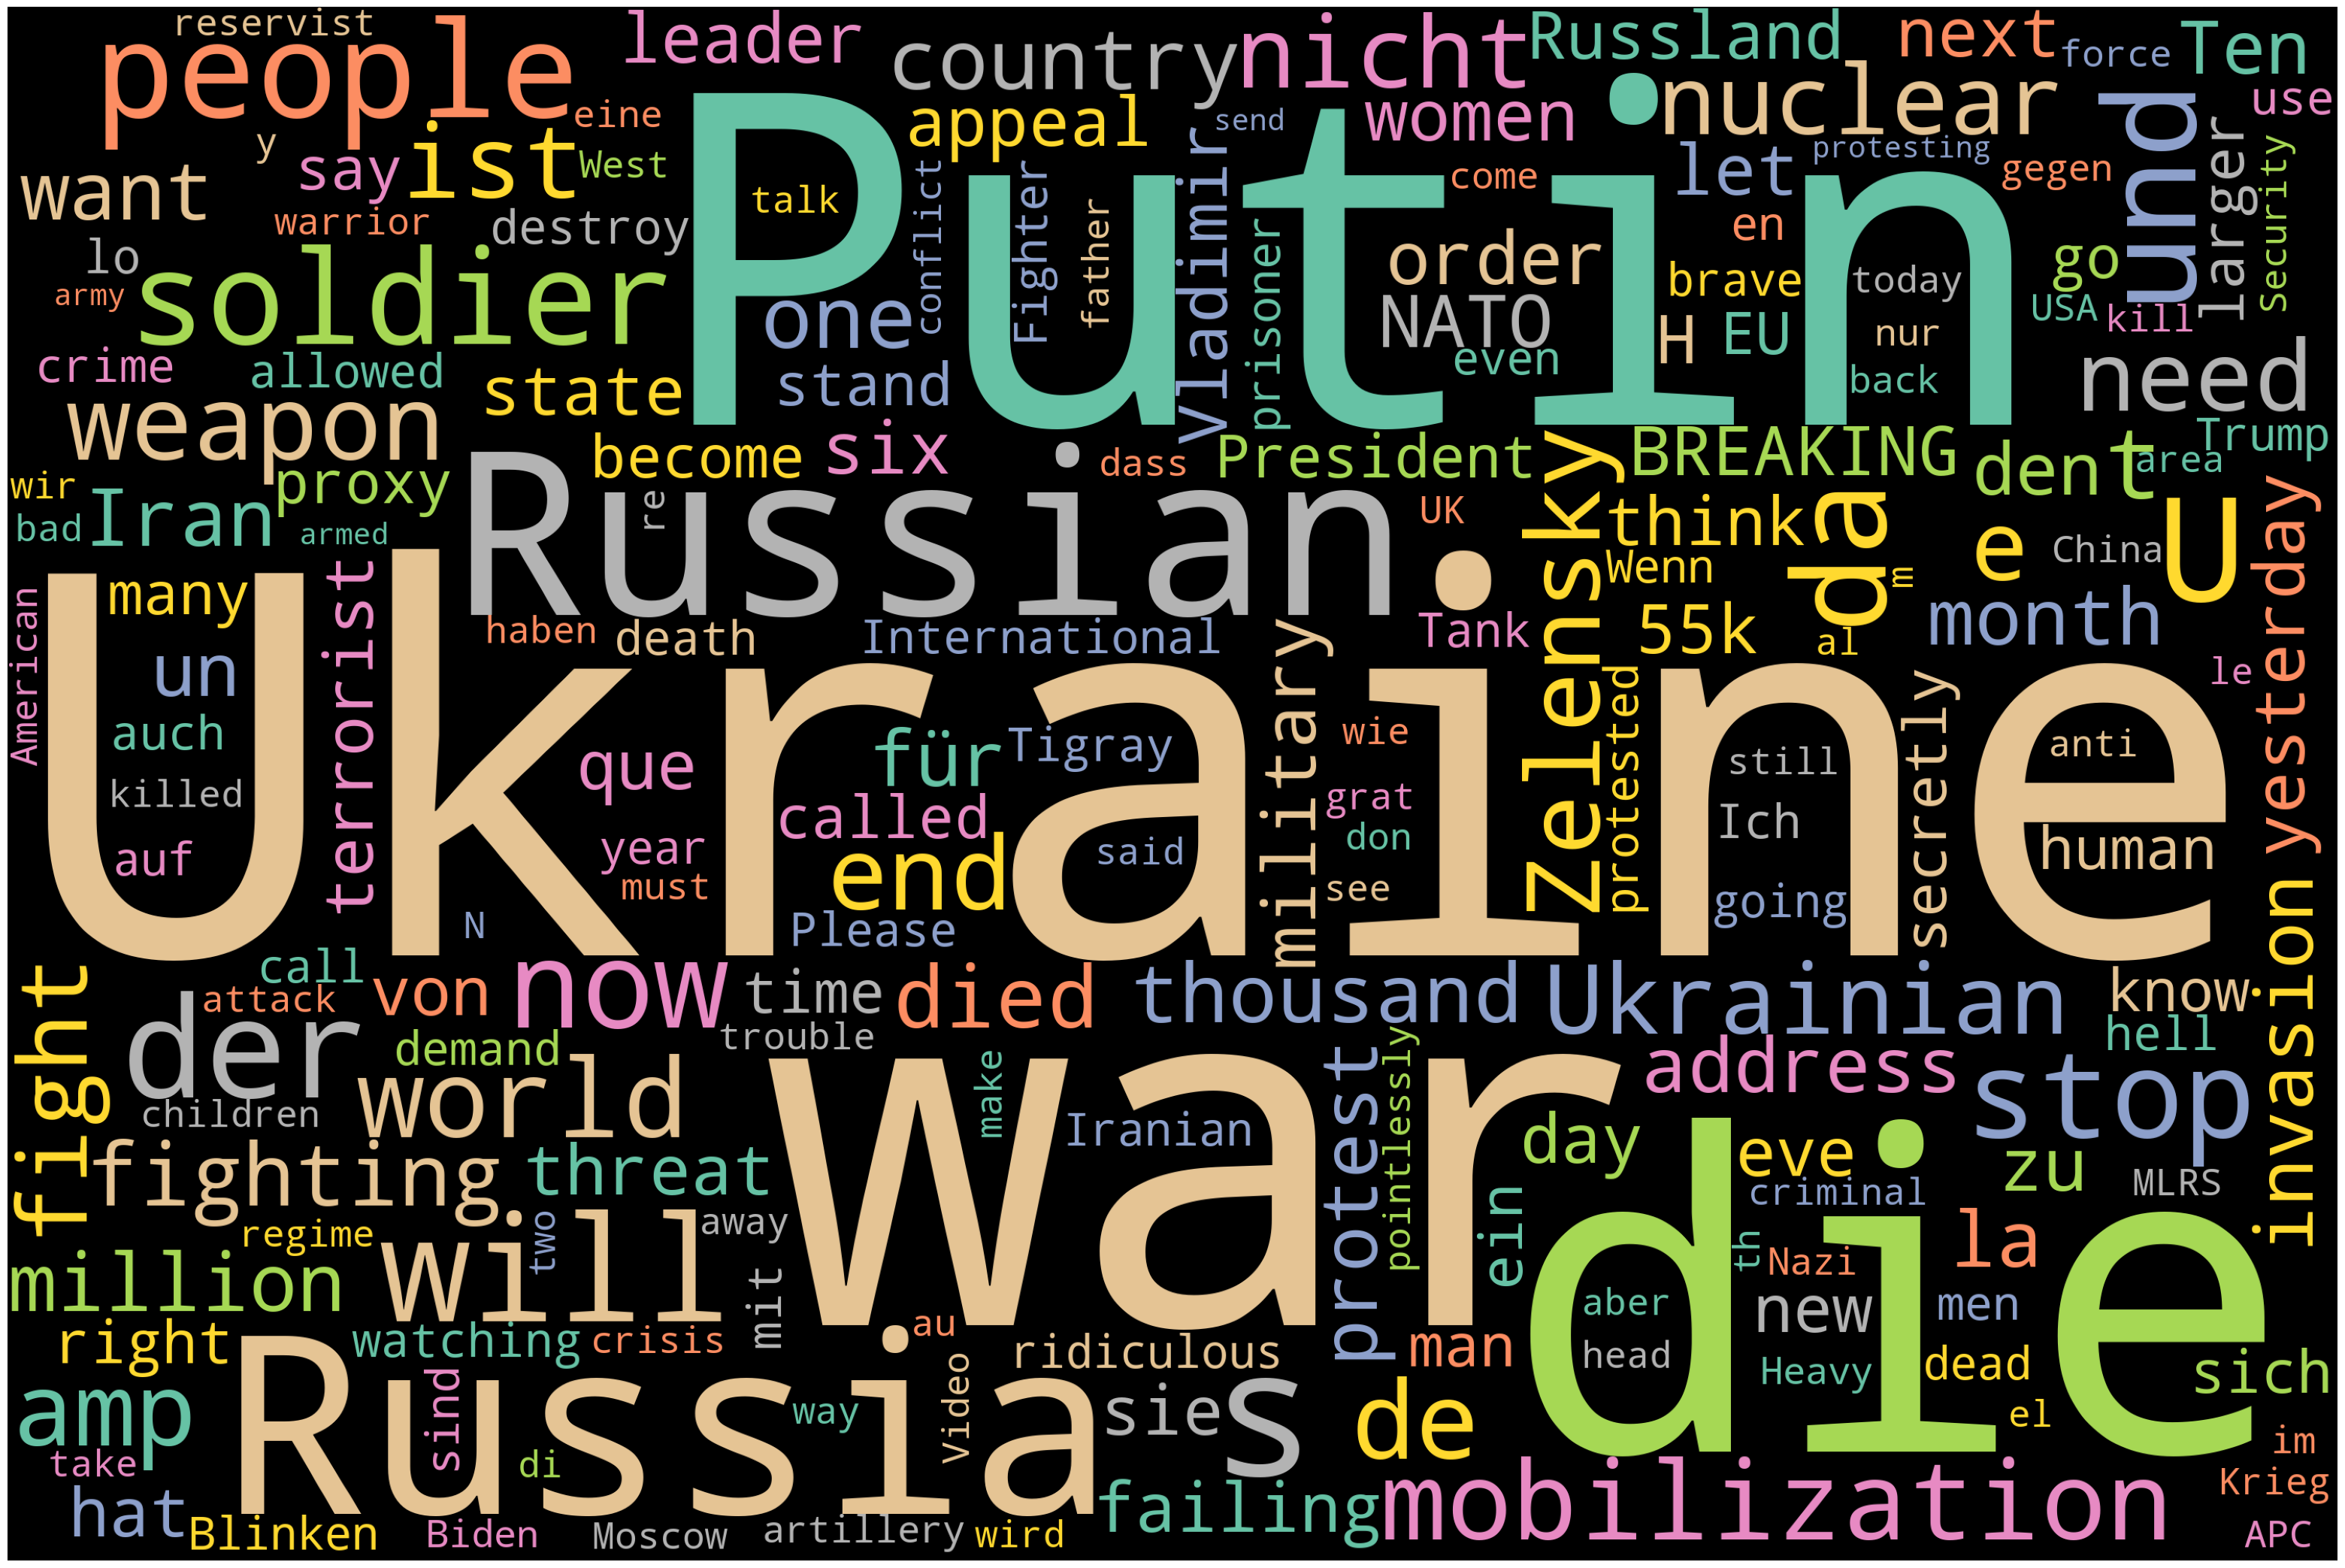

In [22]:
#wordcloud for Negative tweets 
### Word Cloud of mostly used word in Tweets
text = " ".join(review for review in df[df['Category']=='Negative'].Tweet)
wordcloud = WordCloud(width = 3000, height = 2000, stopwords=STOPWORDS, background_color="Black",colormap='Set2', collocations=False).generate(text)
 ### Display the generated image:

plot_cloud(wordcloud)

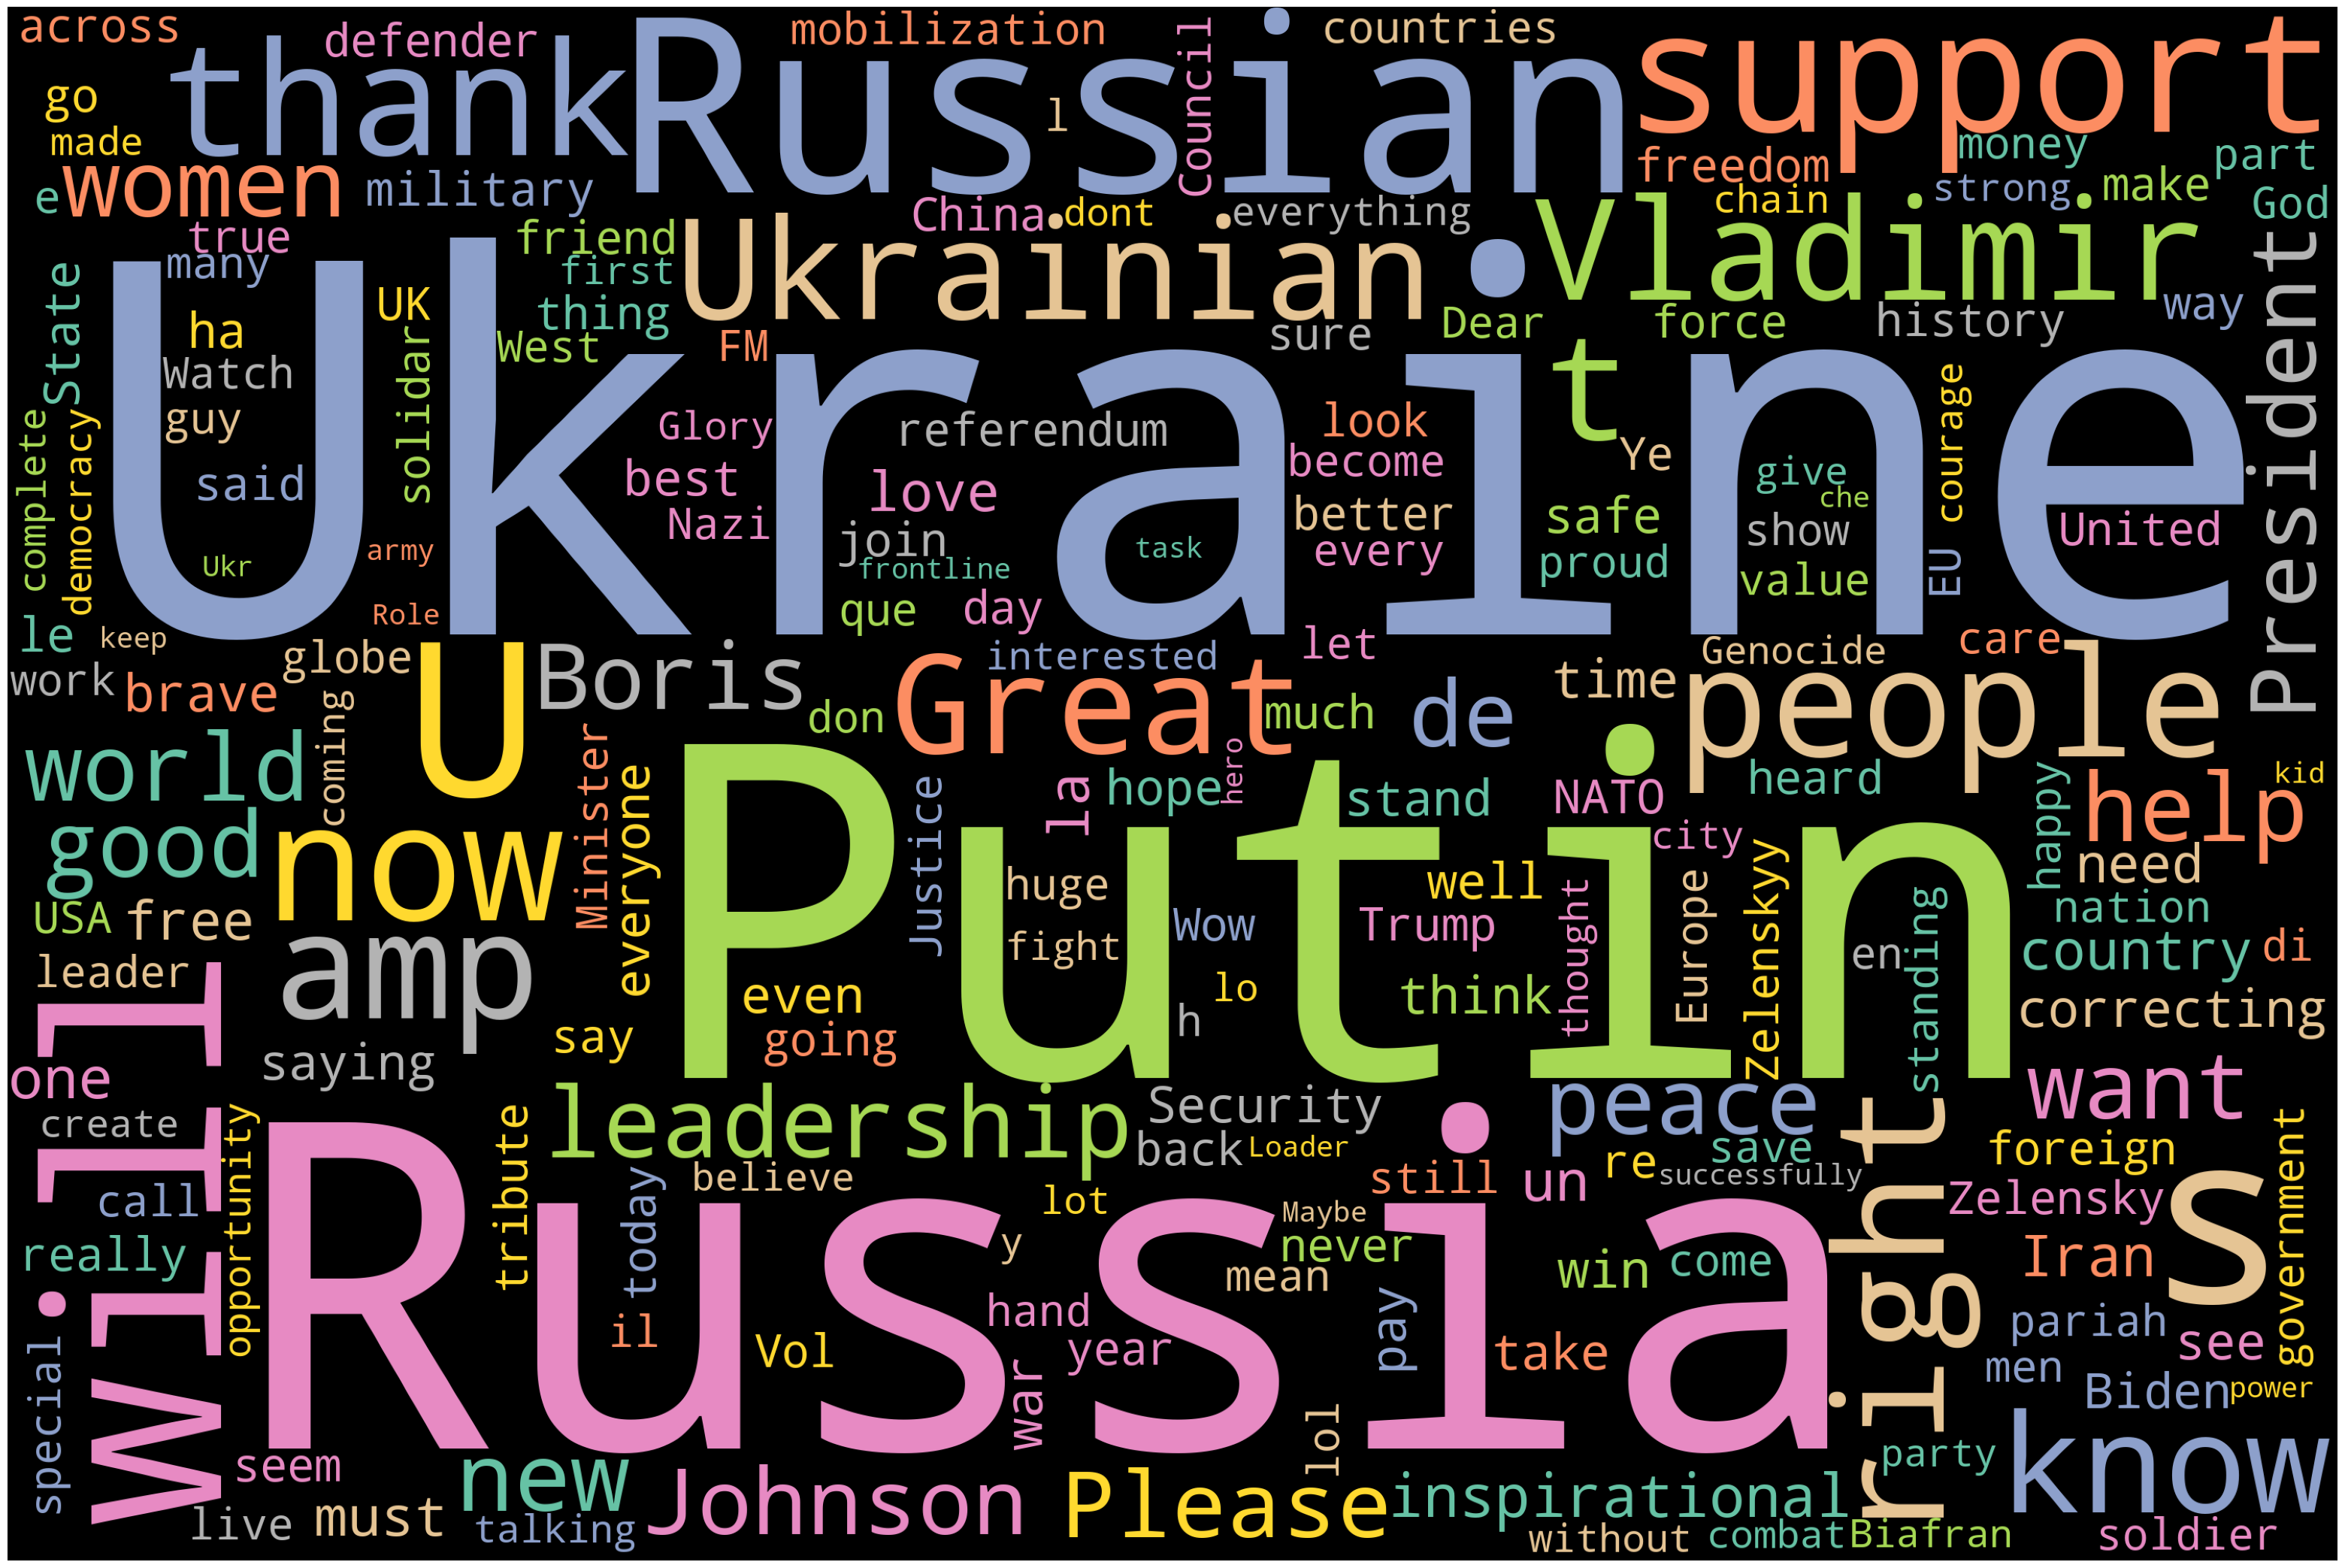

In [23]:
#wordcloud for Positive tweets 
### Word Cloud of mostly used word in Tweets
text = " ".join(review for review in df[df['Category']=='Positive'].Tweet)
wordcloud = WordCloud(width = 3000, height = 2000, stopwords=STOPWORDS, background_color="Black",colormap='Set2', collocations=False).generate(text)
 ### Display the generated image:

plot_cloud(wordcloud)

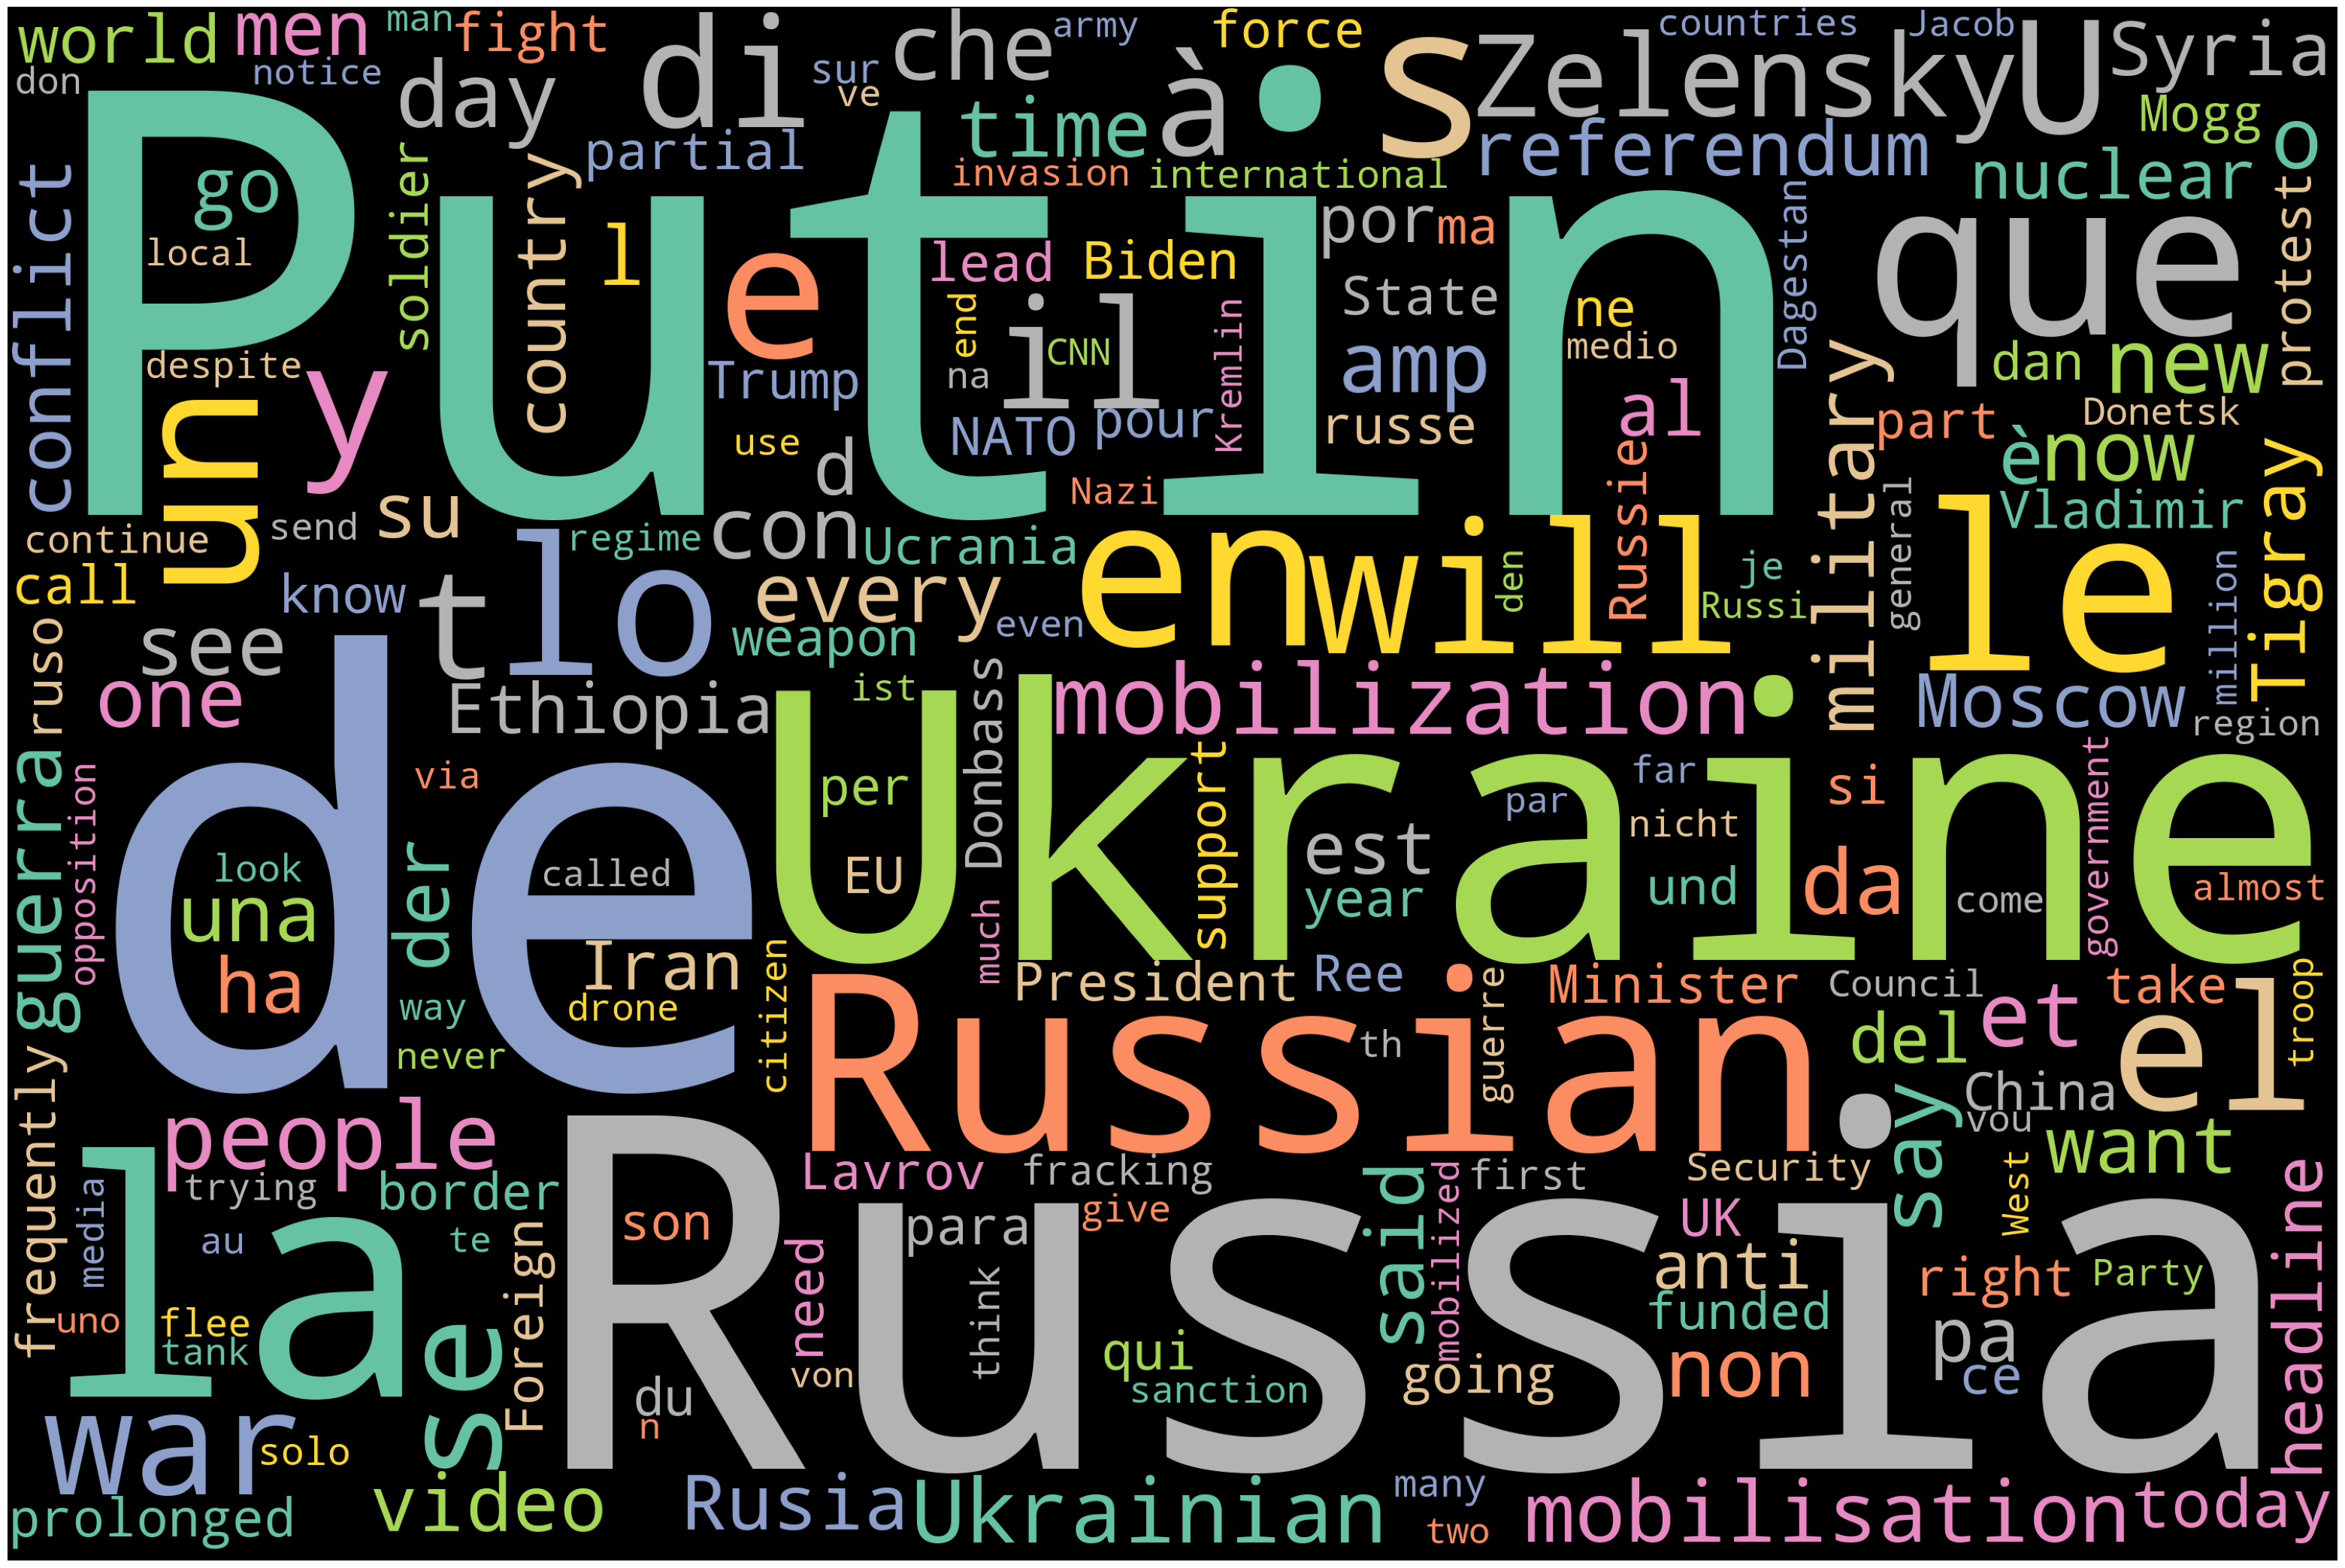

In [24]:
#wordcloud for Neutral tweets 
### Word Cloud of mostly used word in Tweets
text = " ".join(review for review in df[df['Category']=='Neutral'].Tweet)
wordcloud = WordCloud(width = 3000, height = 2000, stopwords=STOPWORDS, background_color="Black",colormap='Set2', collocations=False).generate(text)
 ### Display the generated image:

plot_cloud(wordcloud)